In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot, rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [2]:
# mesh paramters
nx = 81
dx = 0.25
dt = 0.0002 # this is supposed to be 0.0002!
nt = int(0.01/dt)+1
gamma = 1.4

x = numpy.linspace(-10,10,nx)

In [3]:
# functions
# initial condition
def init_cond(nx):
    """ Creates initial conditions for shock tube problem.
    Parameters
    ----------
    nx     : array of floats
             the number of spatial divisions
             
    Returns
    -------
    u      : array of floats
             vector u for initial conditions.
    """
    # initialize rho
    rho_init = numpy.zeros(nx)
    rho_init[:int((nx-1)/2)] = 1.    # left side density = 1 kg/m^3
    rho_init[int((nx-1)/2):] = 0.125 # right side density = 0.125 kg/m^3
    
    # initialize u
    u_init = numpy.zeros(nx) # all velocity is initially zero
    
    #initialize pressure
    p_init = numpy.zeros(nx)
    p_init[:int((nx-1)/2)] = 100e3 # left side pressure = 100 kPa
    p_init[int((nx-1)/2):] = 10e3  # right side pressure = 10 kPa
    
    # initialize u
    u = numpy.ndarray(shape=(3, nx))
    u[0,:] = rho_init         # puts rho_init into each row to clear junk
    u[1,:] = rho_init*u_init  # same for rho*u and rho*e_t:
    u[2,:] = rho_init*(p_init/((gamma-1)*rho_init) + u_init**2/2)
    return u

# flux
def computeF(u):
     """ Calculates flux vector for the Sod's shock tube problem.
    Parameters
    ----------
    u     : array of floats
            vector for shock problem
             
    Returns
    -------
    f      : array of floats.
             flux vector for shock problem
    """
    u1 = u[0]
    u2 = u[1]
    u3 = u[2]
    return numpy.array([u2,
                        u2**2/u1 + (gamma-1)*(u3 - 0.5*u2**2/u1),
                        (u3 + (gamma - 1)*(u3 - 0.5*u2**2/u1))*(u2/u1)])

# Richtmyer method
def richtmyer(u, dx, dt, nt):
    """ Performs Richtmyer scheme for the shock tube problem.
    Parameters
    ----------
    u     : array of floats
            vector for shock problem
    
    dx    : float
            spatial discritization 
            
    dt    : float
            temporal discritization
            
    nt    : int
            number of time steps
             
    Returns
    -------
    u_n   : multidimensional array of floats.
            contains solution to shock problem at each time step.
            u_n[]
    """
    # initialize our multidimensional results array with dimension 3 by nt by nx
    u_n = numpy.ndarray(shape=(3, nt, nx))
    for i in range(0,nt):
        u_n[:,i,:] = u[:,:].copy() # replaces junk with initial condition
    
    # intermediate time variable array:
    u_half = numpy.zeros(shape=(3,nx))
    u_half = u_n[:,0,:].copy()
    F_half = numpy.zeros(shape=(3,nx))
    
    for t in range(1,nt):
        # first step
        F_half[:,:] = computeF(u[:,:])
        u_half[:,:-1] = 0.5*(u[:,1:] + u[:,:-1]) - dt/(2*dx)*(F_half[:,1:] - F_half[:,:-1])
        # second step
        F = computeF(u_half)
        u_n[:,t,1:-1] = u[:,1:-1] - dt/dx*(F[:,1:-1] - F[:,:-2]) # should be len=79
        u = u_n[:,t,:].copy()
    return u_n

In [4]:
# this block solves the problem
u = init_cond(nx)
u_n = richtmyer(u,dx,dt,nt)

time = 0.01 # time at which answers are asked for
time_ind = int(time/dt)

# velocity array at the above indicated time step
velocity = numpy.zeros(nx)
velocity = u_n[1,time_ind,:]/u_n[0,time_ind,:]

# pressure array at the above indicated time step
pressure = numpy.zeros(nx)
pressure = (gamma - 1)*(u_n[2,time_ind,:] - 0.5*u_n[1,time_ind,:]**2/u_n[0,time_ind,:])

# density array at the above indicated time step
density = numpy.zeros(nx)
density = u_n[0,time_ind,:]

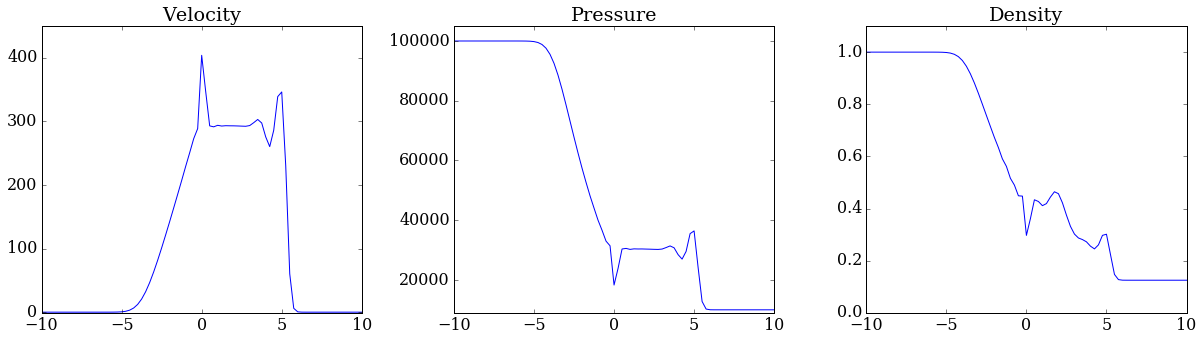

In [26]:
# plot the resulting velocity, pressure, and density distributions
fig = pyplot.figure(figsize=(17,5));
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.set_title('Velocity')
ax1.set_xlim([-10,10])
ax1.set_ylim([-1,450])
ax1.plot(x,velocity)

ax2.set_title('Pressure')
ax2.set_xlim([-10,10])
ax2.set_ylim([9e3,105e3])
ax2.plot(x,pressure)

ax3.set_title('Density')
ax3.set_xlim([-10,10])
ax3.set_ylim([0,1.1])
ax3.plot(x,density);

pyplot.tight_layout()

In [24]:
# print out answers to questions:
space = 2.5 # point at which answers are requested
space_ind = int(numpy.where(x==2.5)[0])
print('The velocity at x = %0.1f [m] is: %0.2f [m/s]' %(space, velocity[space_ind]))
print('The pressure at x = %0.1f [m] is: %0.2f [Pa]' %(space, pressure[space_ind]))
print('The density at x = %0.1f [m] is: %0.2f [kg/m^3]' %(space, density[space_ind]))

The velocity at x = 2.5 [m] is: 292.61 [m/s]
The pressure at x = 2.5 [m] is: 30250.89 [Pa]
The density at x = 2.5 [m] is: 0.37 [kg/m^3]
